In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df=pd.read_csv(r'TESS.csv', comment='#' )

In [4]:
df.head()

,toi,tid,tfopwg_disp,rastr,ra,decstr,dec,st_pmra,st_pmraerr1,st_pmraerr2,...,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_rad,st_raderr1,st_raderr2,st_radlim,toi_created,rowupdate
0,1000.01,50365310,FP,07h29m25.85s,112.357708,-12d41m45.46s,-12.695960,-5.964,0.085,-0.085,...,4.19,0.07,-0.07,0,2.16986,0.072573,-0.072573,0,2019-07-24 15:58:33,2024-09-09 10:08:01
1,1001.01,88863718,PC,08h10m19.31s,122.580465,-05d30m49.87s,-5.513852,-4.956,0.102,-0.102,...,4.03,0.09,-0.09,0,2.01000,0.090000,-0.090000,0,2019-07-24 15:58:33,2023-04-03 14:31:04
2,1002.01,124709665,FP,06h58m54.47s,104.726966,-10d34m49.64s,-10.580455,-1.462,0.206,-0.206,...,NaN,NaN,NaN,0,5.73000,NaN,NaN,0,2019-07-24 15:58:33,2022-07-11 16:02:02
3,1003.01,106997505,FP,07h22m14.39s,110.559945,-25d12m25.26s,-25.207017,-0.939,0.041,-0.041,...,4.15,1.64,-1.64,0,NaN,NaN,NaN,0,2019-07-24 15:58:33,2022-02-23 10:10:02
4,1004.01,238597883,FP,08h08m42.77s,122.178195,-48d48m10.12s,-48.802811,-4.496,0.069,-0.069,...,4.14,0.07,-0.07,0,2.15000,0.060000,-0.060000,0,2019-07-24 15:58:33,2024-09-09 10:08:01


In [5]:
df = df.drop(columns=['toi', 'tid','rastr','ra','decstr','st_pmra','st_pmdec','pl_tranmid','pl_insol','pl_eqt','st_dist','toi_created','rowupdate','st_pmralim','pl_tranmidlim','pl_trandeplim','pl_trandurh','pl_trandurhlim','st_tefflim','st_distlim','st_tmaglim','st_radlim','st_pmdeclim','pl_orbperlim','pl_radelim','pl_insolerr1','pl_insolerr2','pl_insollim','pl_eqterr1','pl_eqterr2','pl_eqtlim','st_logglim'],errors='ignore')


In [6]:
mapping = {
    "CP": "Planet",
    "KP": "Planet",
    "PC": "Candidate",
    "APC": "Candidate",
    "FP": "False",
    "FA": "False"
}

df["disp_3class"] = df["tfopwg_disp"].map(mapping)
print(df["disp_3class"].value_counts())


disp_3class
Candidate    5139
False        1294
Planet       1266
Name: count, dtype: int64


In [7]:

numeric_df = df.select_dtypes(include=['float64', 'int64'])


In [8]:
from sklearn.preprocessing import StandardScaler


In [9]:
X = numeric_df
X = X.dropna(axis=1, thresh=len(X)*0.7)  
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)  

In [12]:
from sklearn.preprocessing import LabelEncoder
y = df["disp_3class"]   

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(le.classes_)   # ['Candidate' 'False' 'Planet']
# now y_encoded = [0, 1, 2]
from sklearn.model_selection import train_test_split



['Candidate' 'False' 'Planet']


# log transformations to stabilize distributions 

*Many features (orbital period) are highly skewed, we could reduce influence of extreme values, make distributions closer to normal.*

In [13]:
df["log_orbper"] = np.log1p(df["pl_orbper"])
df['sqrt_pl_rade']=np.sqrt(df['pl_rade']) #small rocky vs giant planets, can linearize relation with depth.
df['log_trandep'] = np.log1p(df['pl_trandep']*1e6)

# Ratios&Normalizations (instead of raw numbers)

In [14]:
df["rel_radius"] = df["pl_rade"] / df["st_rad"] #Planet radius / star radius= relative planet size
df["depth_norm"] = df["pl_trandep"] / df["st_rad"] #Transit depth / stellar radius=signal relative to star size
df['compactness'] = df['pl_orbper'] / df['st_rad'] #Orbital Compactness. Encodes how “close-in” the planet is relative to star size.

# PrincipalComponentAnalysis

*linear combinations of features that capture maximum variance, mathematical compression*
Noise reduction: Instead of keeping 50 noisy features, you keep top 5 PCs explaining ~70% variance.
Pattern detection: Sometimes clusters separate more cleanly in PC-space than raw space.
Feature compression: PCs can be added as new engineered features alongside physical ones.

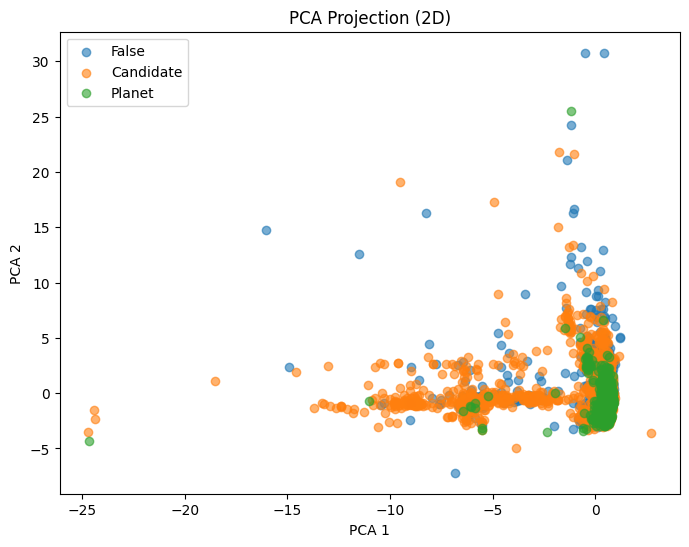

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
for i in range(5):
    df[f"pca_{i+1}"] = X_pca[:, i]


plt.figure(figsize=(8,6))
for label in y.unique():
    idx = (y == label)
    plt.scatter(df.loc[idx, "pca_1"], df.loc[idx, "pca_2"], alpha=0.6, label=label)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA Projection (2D)")
plt.legend()
plt.show()


# Baseline Models

**Logistic Regression, Random Forest Classifier, XGBoost**

In [16]:
y = df["disp_3class"]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, stratify=y, random_state=42
)

In [32]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=500, class_weight="balanced", random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
y_prob_logreg = logreg.predict_proba(X_test)

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)

In [19]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=True,
    eval_metric="mlogloss",
    random_state=42
)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)

C:\Users\Влада\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:53:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


**Neural Network Model**

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

n_features = X.shape[1]
n_classes = len(set(y_encoded))

nn_model = keras.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation="softmax")
])

nn_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

nn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,291 (16.76 KB)

 Trainable params: 4,291 (16.76 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores, f1_scores = [], []

for train_idx, test_idx in skf.split(X_scaled, y_encoded):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
    
    # build fresh model each fold
    nn_model = keras.Sequential([
        layers.Input(shape=(n_features,)),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(n_classes, activation="softmax")
    ])
    nn_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
    
    nn_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
    
    # predictions
    y_proba = nn_model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_proba, axis=1)
    
    # metrics
    auc = roc_auc_score(y_test, y_proba, multi_class="ovr")
    f1 = f1_score(y_test, y_pred, average="macro")
    
    auc_scores.append(auc)
    f1_scores.append(f1)

print("NN ROC AUC (cv mean):", np.mean(auc_scores))
print("NN F1 Score (cv mean):", np.mean(f1_scores))


NN ROC AUC (cv mean): 0.7802966550160723
NN F1 Score (cv mean): 0.5008402276325717


              precision    recall  f1-score   support

   Candidate       0.86      0.55      0.67      1028
       False       0.39      0.66      0.49       259
      Planet       0.43      0.75      0.54       253

    accuracy                           0.60      1540
   macro avg       0.56      0.65      0.57      1540
weighted avg       0.71      0.60      0.62      1540

ROC AUC: 0.7984934282107904


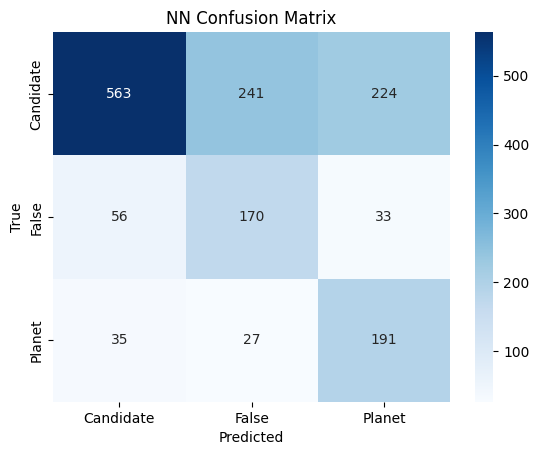

In [30]:
# Final train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Build final NN
nn_model = keras.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation="softmax")
])
nn_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
from sklearn.utils.class_weight import compute_class_weight


class_weights = dict(zip(
    np.unique(y_train),
    compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
))
nn_model.fit(X_train, y_train, epochs=30, batch_size=32, class_weight=class_weights, verbose=0)

# Predictions
y_proba = nn_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_proba, axis=1)

print(classification_report(y_test, y_pred, target_names=le.classes_))
print("ROC AUC:", roc_auc_score(y_test, y_proba, multi_class="ovr"))

import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("NN Confusion Matrix")
plt.show()


# Evaluation

Cross Validation Scores

In [20]:
from sklearn.model_selection import cross_val_score

for model, name in [(logreg, "LogReg"), (rf, "RandomForest"), (xgb, "XGBoost")]:
    scores = cross_val_score(model, X_scaled, y_encoded, cv=5, scoring="roc_auc_ovr")
    print(f"{name} ROC AUC (cv mean): {scores.mean():.3f}")


LogReg ROC AUC (cv mean): 0.713
RandomForest ROC AUC (cv mean): 0.800


C:\Users\Влада\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:53:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Влада\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:53:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Влада\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:53:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Влада\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:53:58] WARNING: C:\actio

XGBoost ROC AUC (cv mean): 0.805


In [21]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_fscore_support

*Confusion Matrix*

In [22]:
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
print("Logistic Regression Confusion Matrix:\n", cm_logreg)

cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Random Forest Confusion Matrix:\n", cm_rf)

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("XGBoost Confusion Matrix:\n", cm_xgb)


Logistic Regression Confusion Matrix:
 [[562 178 288]
 [ 70 130  59]
 [ 49  26 178]]
Random Forest Confusion Matrix:
 [[978  15  35]
 [203  55   1]
 [142   1 110]]
XGBoost Confusion Matrix:
 [[943  41  44]
 [148 105   6]
 [113   5 135]]


*ROC AUC*

In [25]:
roc_auc_logreg = roc_auc_score(y_test, y_prob_logreg, multi_class="ovr")
print(f"Logistic Regression ROC AUC: {roc_auc_logreg:.3f}")

roc_auc_rf = roc_auc_score(y_test, y_prob_rf, multi_class="ovr")
print(f"Random Forest ROC AUC: {roc_auc_rf:.3f}")

roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb, multi_class="ovr")
print(f"XGBoost ROC AUC: {roc_auc_rf:.3f}")

Logistic Regression ROC AUC: 0.738
Random Forest ROC AUC: 0.842
XGBoost ROC AUC: 0.842


*Precision Recall F1*

In [24]:
precision_logreg, recall_logreg, f1_logreg, _ = precision_recall_fscore_support(y_test, y_pred_logreg, average="weighted")
print(f"Logistic Regression Precision: {precision_logreg:.3f}, Recall: {recall_logreg:.3f}, F1: {f1_logreg:.3f}")

precision_rf, recall_rf, f1_rf, _ = precision_recall_fscore_support(y_test, y_pred_rf, average="weighted")
print(f"Random Forest Precision: {precision_rf:.3f}, Recall: {recall_rf:.3f}, F1: {f1_rf:.3f}")

precision_xgb, recall_xgb, f1_xgb, _ = precision_recall_fscore_support(y_test, y_pred_xgb, average="weighted")
print(f"XGBoost Precision: {precision_xgb:.3f}, Recall: {recall_xgb:.3f}, F1: {f1_xgb:.3f}")

Logistic Regression Precision: 0.672, Recall: 0.565, F1: 0.588
Random Forest Precision: 0.748, Recall: 0.742, F1: 0.702
XGBoost Precision: 0.760, Recall: 0.768, F1: 0.751


# Ensemble

*1st version*

In [41]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# --- Fit traditional models ---
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# --- Train NN separately ---
nn_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

# --- Get prediction probabilities ---
proba_lr = log_reg.predict_proba(X_test)
proba_rf = rf.predict_proba(X_test)
proba_xgb = xgb.predict_proba(X_test)
proba_nn = nn_model.predict(X_test)

# --- Simple soft voting (average) ---
proba_ensemble = (proba_lr + proba_rf + proba_xgb + proba_nn) / 4
y_pred_ensemble = np.argmax(proba_ensemble, axis=1)

# --- Evaluate ---
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
print(classification_report(y_test, y_pred_ensemble))

cm = confusion_matrix(y_test, y_pred_ensemble)
print("Confusion matrix:\n", cm)

roc_auc = roc_auc_score(y_test, proba_ensemble, multi_class="ovr")
print("ROC AUC:", roc_auc)


C:\Users\Влада\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:41:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

           0       0.75      0.95      0.84      1028
           1       0.75      0.26      0.39       259
           2       0.73      0.44      0.55       253

    accuracy                           0.75      1540
   macro avg       0.74      0.55      0.59      1540
weighted avg       0.75      0.75      0.71      1540

Confusion matrix:
 [[973  20  35]
 [185  68   6]
 [138   3 112]]
ROC AUC: 0.851655833844943


*2nd Version*

In [43]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# --- Fit traditional models ---
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# --- Train NN separately ---
nn_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

proba_ensemble = (
    0.25 * proba_lr +
    0.25 * proba_rf +
    0.25 * proba_xgb +
    0.25 * proba_nn
)

# Try rebalancing
weights = np.array([1.0, 1.3, 1.3])   # boost False & Planet
proba_ensemble *= weights
proba_ensemble = proba_ensemble / proba_ensemble.sum(axis=1, keepdims=True)
y_pred_ensemble = np.argmax(proba_ensemble, axis=1)

# --- Evaluate ---
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
print(classification_report(y_test, y_pred_ensemble))

cm = confusion_matrix(y_test, y_pred_ensemble)
print("Confusion matrix:\n", cm)

roc_auc = roc_auc_score(y_test, proba_ensemble, multi_class="ovr")
print("ROC AUC:", roc_auc)


C:\Users\Влада\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:51:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.78      0.92      0.84      1028
           1       0.73      0.38      0.50       259
           2       0.69      0.52      0.59       253

    accuracy                           0.76      1540
   macro avg       0.73      0.61      0.65      1540
weighted avg       0.75      0.76      0.74      1540

Confusion matrix:
 [[943  34  51]
 [152  99   8]
 [118   3 132]]
ROC AUC: 0.8524780666283722


*3rd Version*

In [47]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Neural Net
nn = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])
nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Neural net expects one-hot encoded targets
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
nn.fit(X_train, y_train_cat, epochs=20, batch_size=32, verbose=0)

#. Generate meta-features ===
proba_lr_train = lr.predict_proba(X_train)
proba_rf_train = rf.predict_proba(X_train)
proba_xgb_train = xgb.predict_proba(X_train)
proba_nn_train = nn.predict(X_train, verbose=0)

proba_lr_test = lr.predict_proba(X_test)
proba_rf_test = rf.predict_proba(X_test)
proba_xgb_test = xgb.predict_proba(X_test)
proba_nn_test = nn.predict(X_test, verbose=0)

# Stack them horizontally to form new datasets
X_meta_train = np.hstack([proba_lr_train, proba_rf_train, proba_xgb_train, proba_nn_train])
X_meta_test = np.hstack([proba_lr_test, proba_rf_test, proba_xgb_test, proba_nn_test])

#Train meta-model
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(X_meta_train, y_train)

# Evaluate
y_pred_meta = meta_model.predict(X_meta_test)
y_proba_meta = meta_model.predict_proba(X_meta_test)

print("\n=== Classification Report (Stacked Ensemble) ===")
print(classification_report(y_test, y_pred_meta, digits=2))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_meta))

roc_auc = roc_auc_score(y_test, y_proba_meta, multi_class='ovr')
print("ROC AUC:", roc_auc)


C:\Users\Влада\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Влада\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:03:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Classification Report (Stacked Ensemble) ===
              precision    recall  f1-score   support

           0       0.79      0.91      0.84      1028
           1       0.71      0.43      0.54       259
           2       0.69      0.53      0.60       253

    accuracy                           0.77      1540
   macro avg       0.73      0.62      0.66      1540
weighted avg       0.76      0.77      0.75      1540

Confusion matrix:
[[934  41  53]
 [140 112   7]
 [114   4 135]]
ROC AUC: 0.832427848856315
